# The requirement:

You are asked to create a Gesture Detection model for MCUs that can detect a ***punch*** or a ***flex*** gesture by a potential client. The clients would like to recognise any gestures using the data gathered by the onboard ***IMU (Inertial Measurement Unit)*** that provides Gyroscopic and Accelerometer data.



## Prerequisites

Download the `punch.csv` and `flex.csv` files into a local folder from [this](https://drive.google.com/drive/folders/1srh0-_dL9kl_smUPqLtlK1Kzj44sCIDH?usp=sharing) link

Acknowledgement:

Contents of the notebook are based on Don Coleman, Sandeep Mistry's Gesture recognition exercise 

### Important preliminary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#### Method used by me:
* Uploading the `punch.csv` & `flex.csv` into the colab session using `google.colab.files`

#### Alternatively you can...:
1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

In [2]:
from google.colab import files

uploaded = files.upload()

Saving flex.csv to flex.csv
Saving punch.csv to punch.csv


# Flex Data

Reading and analysing the data imported

In [3]:
flex = pd.read_csv("flex.csv")

In [4]:
flex.head()

,aX,aY,aZ,gX,gY,gZ
0,-0.438,-0.635,2.464,143.982,-121.948,-38.696
1,-0.496,-0.749,2.630,117.737,-98.694,-39.673
2,-0.411,-0.697,2.561,72.693,-70.618,-35.950
3,-0.221,-0.540,2.247,18.799,-39.856,-30.090
4,0.009,-0.301,1.768,-30.701,-11.780,-22.217


In [5]:
flex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3689 entries, 0 to 3688
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aX      3689 non-null   float64
 1   aY      3689 non-null   float64
 2   aZ      3689 non-null   float64
 3   gX      3689 non-null   float64
 4   gY      3689 non-null   float64
 5   gZ      3689 non-null   float64
dtypes: float64(6)
memory usage: 173.0 KB


Visualising the data

In [7]:
flex_index = range(1, len(flex['aX']) + 1)

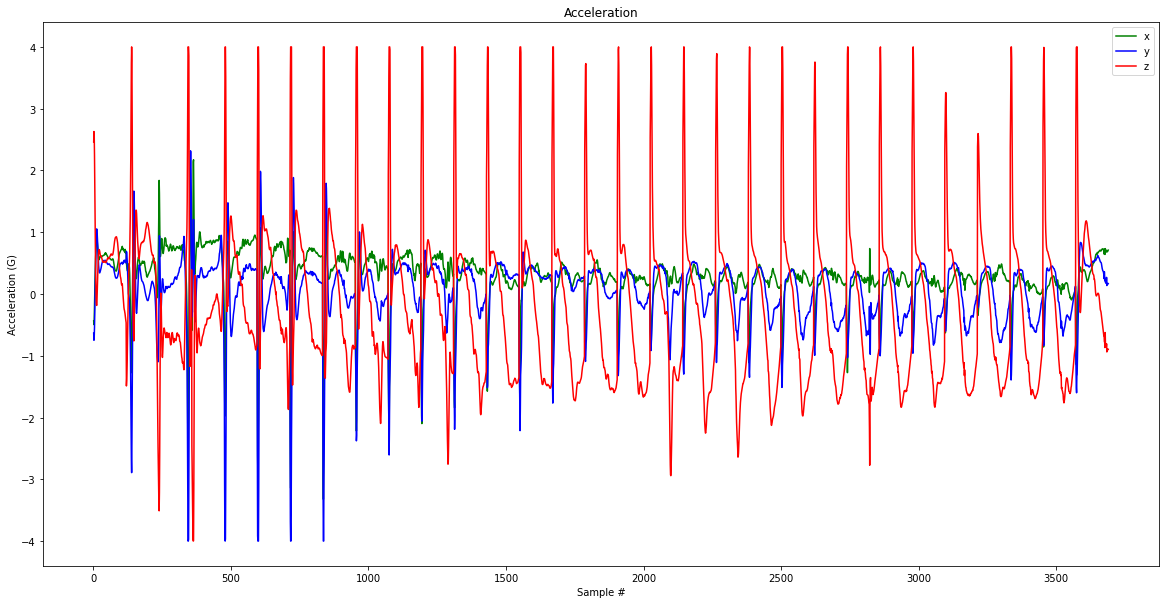

In [8]:
plt.figure(figsize=(20,10)) #Setting the figure size 
plt.plot(flex_index, flex['aX'], 'g', label='x')
plt.plot(flex_index, flex['aY'], 'b', label='y')
plt.plot(flex_index, flex['aZ'], 'r', label='z')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

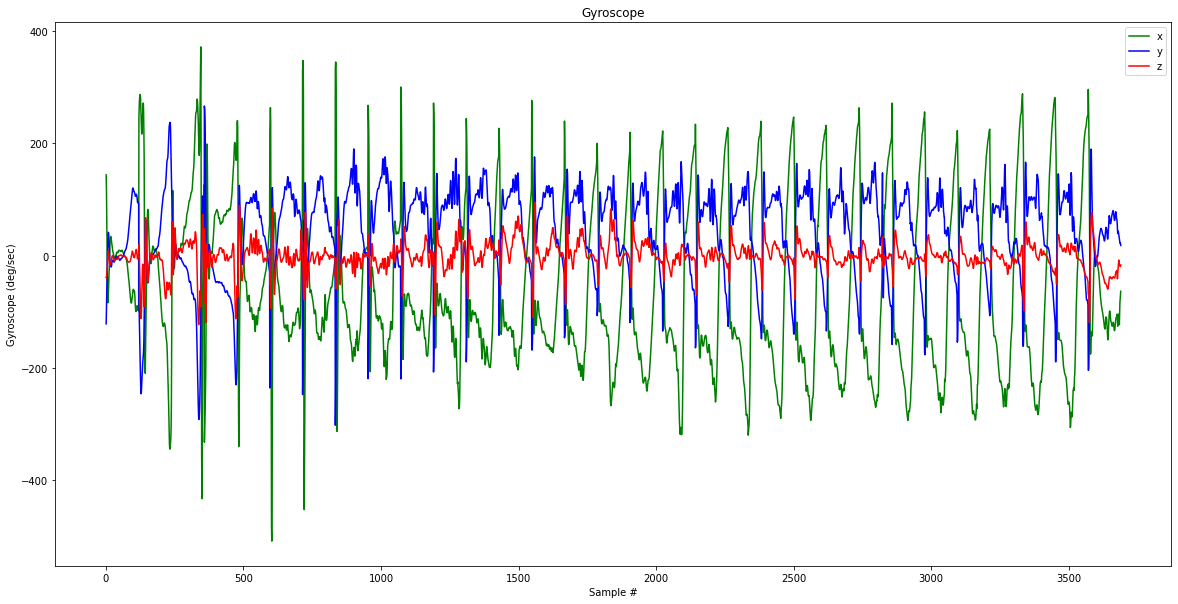

In [9]:
plt.figure(figsize=(20,10))
plt.plot(flex_index, flex['gX'], 'g', label='x')
plt.plot(flex_index, flex['gY'], 'b', label='y')
plt.plot(flex_index, flex['gZ'], 'r', label='z')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

# Punch

In [10]:
punch = pd.read_csv("punch.csv")

In [11]:
punch_index = range(1, len(punch['aX']) + 1)

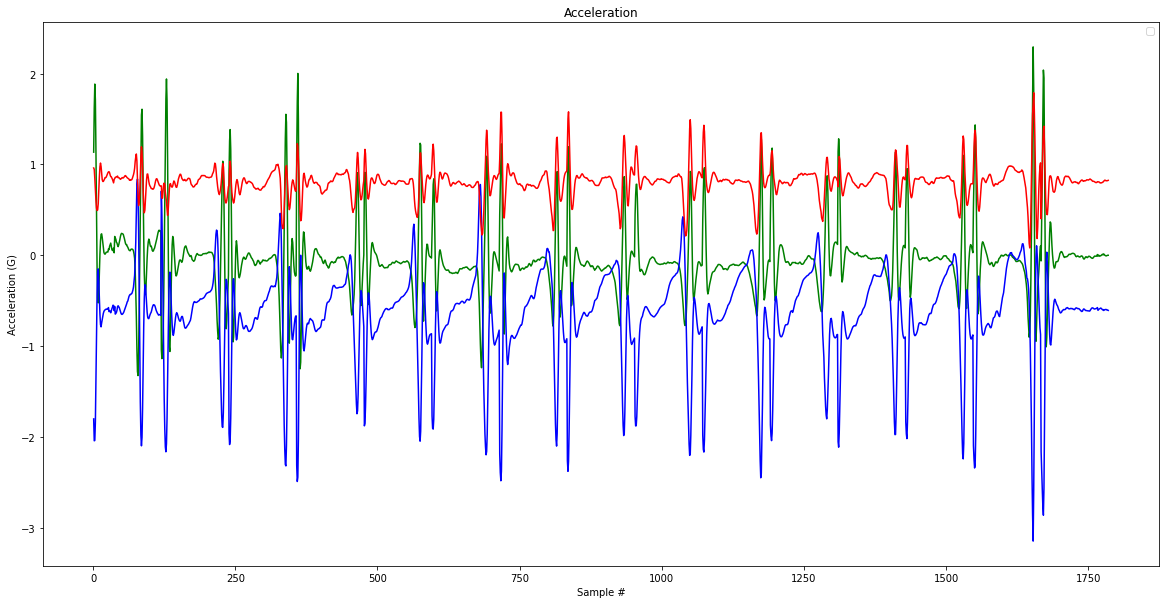

In [12]:
plt.figure(figsize=(20,10))
plt.plot(punch_index, punch['aX'], 'g')
plt.plot(punch_index, punch['aY'], 'b')
plt.plot(punch_index, punch['aZ'], 'r')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

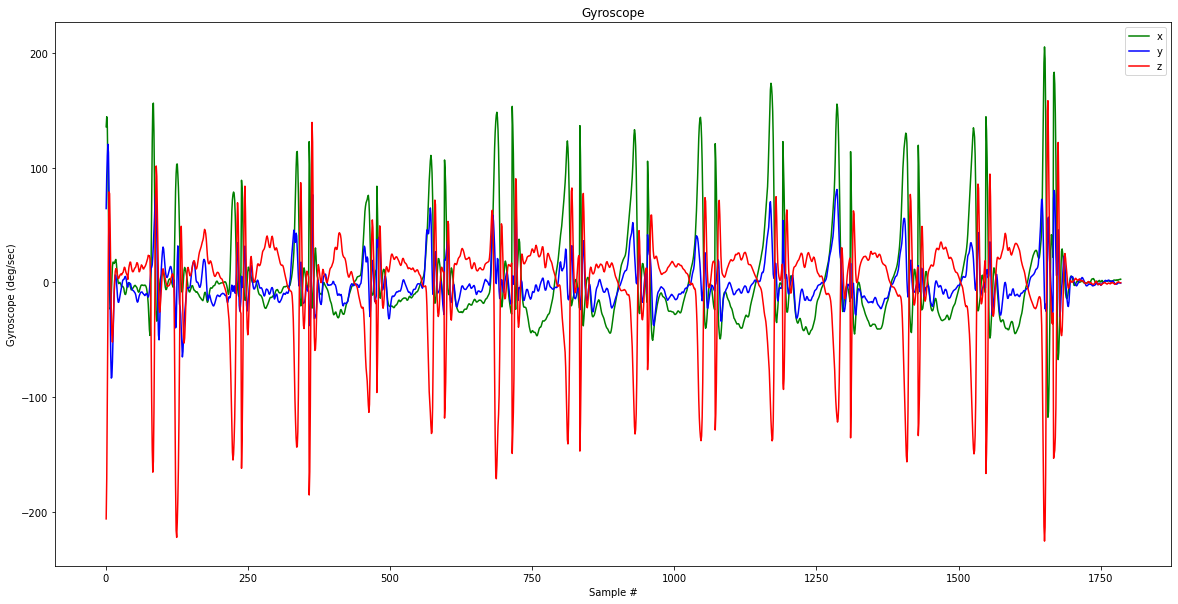

In [13]:
plt.figure(figsize=(20,10))
plt.plot(punch_index, punch['gX'], 'g', label='x')
plt.plot(punch_index, punch['gY'], 'b', label='y')
plt.plot(punch_index, punch['gZ'], 'r', label='z')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

# Compiling the dataset

In [14]:
# Constants
SEED = 1337
SAMPLES_PER_GESTURE = 119 # <-- Sample rate of the Arduino Nano 33 BLE IMU

GESTURES = ["punch", "flex"] # <--- include any new gestures here
NUM_GESTURES = len(GESTURES) # 2

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
print(ONE_HOT_ENCODED_GESTURES)

[[1. 0.]
 [0. 1.]]


In [15]:
print(ONE_HOT_ENCODED_GESTURES)

[[1. 0.]
 [0. 1.]]


#### Why do we need this?

Lets for example say that it's a punch when `aZ` (Acc. in the Z axis) > 2

| Values | Punch | Flex |
|--------|-------|------|
|3.0031| 1 | 0|
|0.1231| 0 | 1 |


### Creating the dataset

In [21]:
# Reproducability(will make sure same random numbers will be produced)
np.random.seed(SEED)
tf.random.set_seed(SEED)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]  # "punch"
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"There are {num_recordings} recordings of the {gesture} gesture (Index #{gesture_index}).")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j

      # Normalizing the data
      # between -4 and +4 for Acceleration
      # between -2000 and 2000 for gyroscopic data
      # convert them to 0 and 1
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)
    #input list contain the six values ax,ay,az,gx,gy,gz which are normalized to 0 to 1 and output list contain the relevant label

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

# print(inputs[0])

print("Completed dataset preparation.")

There are 15 recordings of the punch gesture (Index #0).
There are 31 recordings of the flex gesture (Index #1).
Completed dataset preparation.


#### Why is normalising important?

The goal of normalization is to transform features to be on a similar scale. This improves the performance and training stability of the model.([developer.google](https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=The%20goal%20of%20normalization%20is,training%20stability%20of%20the%20model.))

Randomising the dataset

In [17]:
inputs_count = len(inputs)
randomize = np.arange(inputs_count)
print(randomize)
np.random.shuffle(randomize)
print(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[16  0 13 41  5 12 44 29 21 33 31 10  7 37 32  4  3 15 17 14 19 30 11 36
 35  2 38 22 34 27  1 24 45 43  6  9  8 20 18 26 42 25 39 40 28 23]


In [18]:
# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * inputs_count)
TEST_SPLIT = int(0.2 * inputs_count + TRAIN_SPLIT)

print(TRAIN_SPLIT)
print(TEST_SPLIT)

X_train, X_test, X_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print(len(X_test))

print("Data set randomization and splitting complete.")

27
36
9
Data set randomization and splitting complete.


# Creating the model

In [20]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_validate, y_validate))

Epoch 1/50
27/27 [==============================] - 1s 9ms/step - loss: 0.2830 - mae: 0.4987 - accuracy: 0.5185 - val_loss: 0.2618 - val_mae: 0.5108 - val_accuracy: 0.1000
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 0.2881 - mae: 0.4710 - accuracy: 0.5556 - val_loss: 0.1740 - val_mae: 0.4156 - val_accuracy: 0.9000
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.2239 - mae: 0.4684 - accuracy: 0.6667 - val_loss: 0.1373 - val_mae: 0.3643 - val_accuracy: 0.9000
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.2172 - mae: 0.4490 - accuracy: 0.7778 - val_loss: 0.2035 - val_mae: 0.4506 - val_accuracy: 1.0000
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1968 - mae: 0.4350 - accuracy: 0.7407 - val_loss: 0.1520 - val_mae: 0.3889 - val_accuracy: 1.0000
Epoch 6/50
27/27 [==============================] - 0s 8ms/step - loss: 0.1641 - mae: 0.3956 - accuracy: 0.8519 - val_loss: 0.0790 - val_mae

# Plotting loss graph

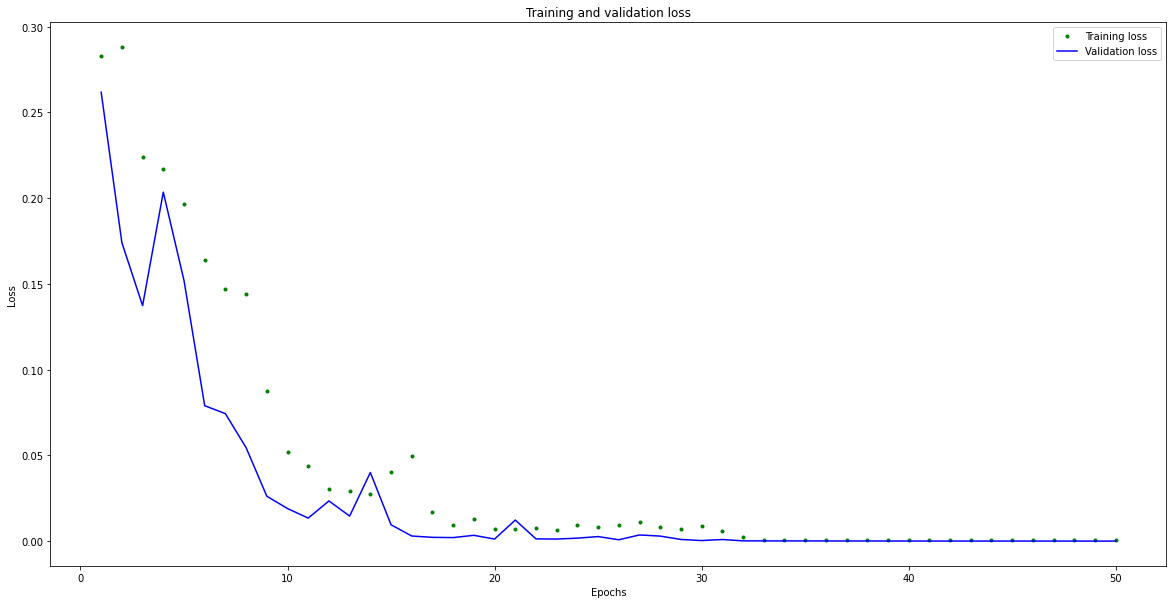

In [22]:
# increase the size of the graphs. The default size is (6,4).
plt.figure(figsize=(20,10))

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy Graphs

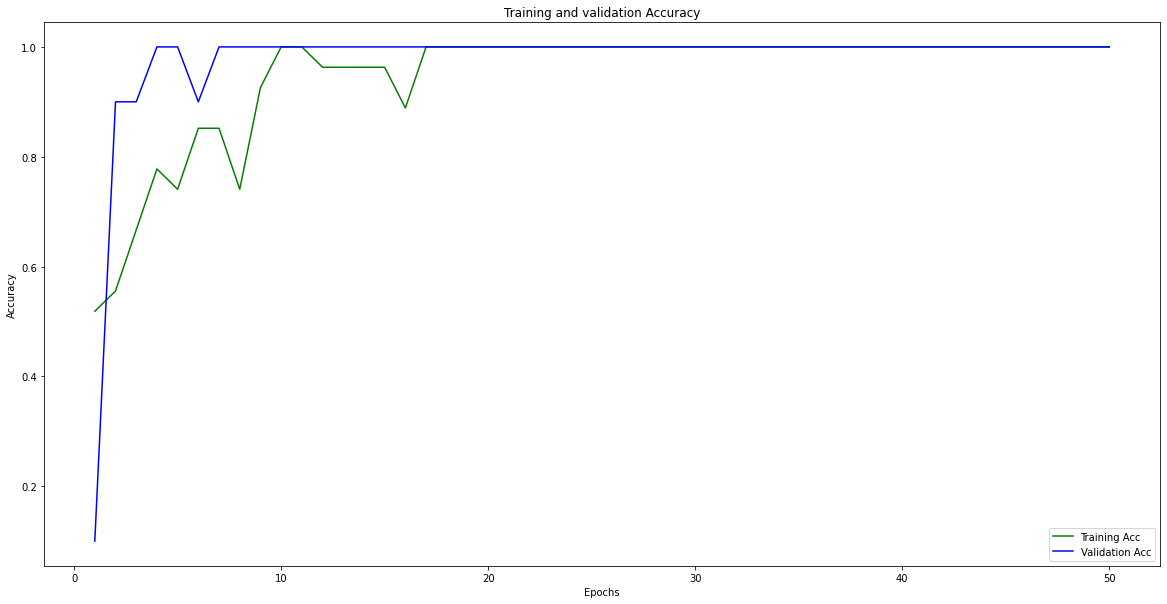

In [23]:
# graph of mean absolute error
plt.figure(figsize=(20,10))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 181ms/step
predictions =
 [[0.004 0.996]
 [0.001 0.999]
 [0.001 0.999]
 [0.855 0.145]
 [0.002 0.998]
 [0.007 0.993]
 [0.002 0.998]
 [0.98  0.02 ]
 [0.976 0.024]]
actual =
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if sys.path[0] == '':


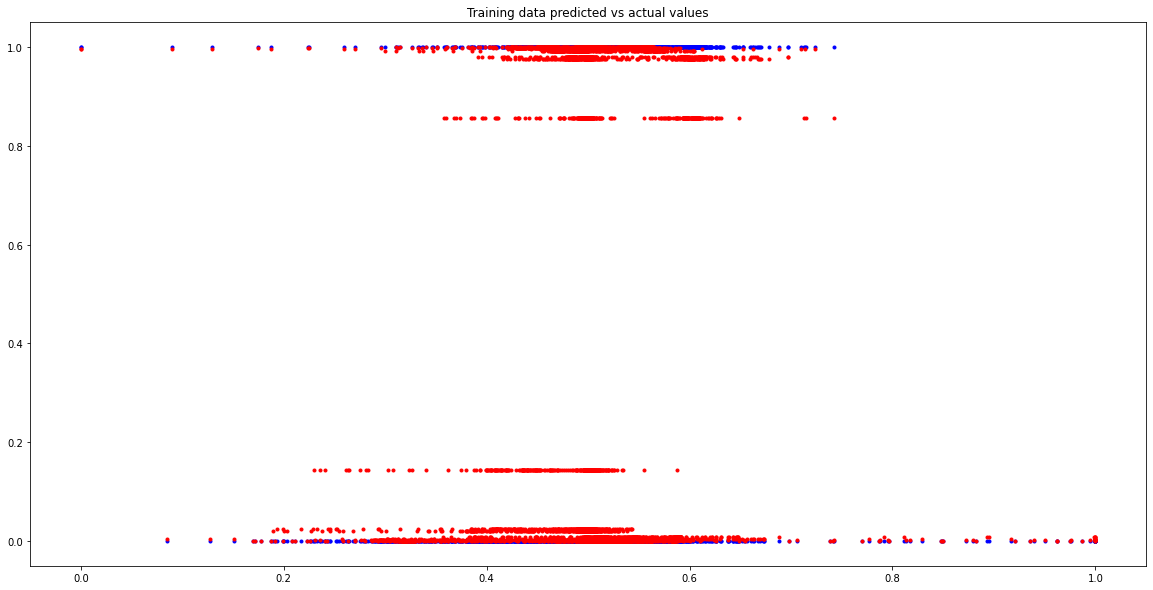

In [25]:
# use the model to predict the test inputs
predictions = model.predict(X_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", y_test)

# Plot the predictions along with to the test data
plt.figure(figsize=(20,10))
plt.title('Training data predicted vs actual values')
plt.plot(X_test, y_test, 'b.', label='Actual')
plt.plot(X_test, predictions, 'r.', label='Predicted')
plt.show()

# Model conversion

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Model is 148256 bytes


# Creating C/C++ Header file for the model

In [26]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 914,280 bytes.
